<a href="https://colab.research.google.com/github/alzaidawi/PORTAL_code/blob/main/CNN_pore_types_pixel_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10
1/1 [==============================] - 83s 83s/step - loss: 0.6824 - accuracy: 0.9269
Epoch 2/10
1/1 [==============================] - 80s 80s/step - loss: 0.5283 - accuracy: 0.9334
Epoch 3/10
1/1 [==============================] - 81s 81s/step - loss: 0.0930 - accuracy: 0.9334
Epoch 4/10
1/1 [==============================] - 85s 85s/step - loss: 0.0815 - accuracy: 0.9334
Epoch 5/10
1/1 [==============================] - 81s 81s/step - loss: 0.0801 - accuracy: 0.9334
Epoch 6/10
1/1 [==============================] - 80s 80s/step - loss: 0.0690 - accuracy: 0.9334
Epoch 7/10
1/1 [==============================] - 81s 81s/step - loss: 0.0436 - accuracy: 0.9334
Epoch 8/10
1/1 [==============================] - 82s 82s/step - loss: 0.0467 - accuracy: 0.9334
Epoch 9/10
1/1 [==============================] - 80s 80s/step - loss: 0.0449 - accuracy: 0.9334
Epoch 10/10
1/1 [==============================] - 2s 2s/step


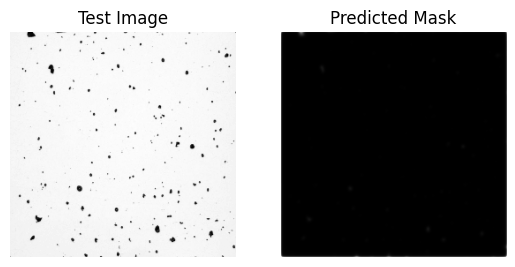

In [2]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Load and preprocess an image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Load and preprocess a mask
def load_and_preprocess_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (256, 256))
    mask = tf.cast(mask, tf.float32) / 255.0
    return mask

# Load the dataset
def load_dataset(image_folder, mask_folder):
    image_paths = glob.glob(os.path.join(image_folder, '*.JPG'))
    mask_paths = glob.glob(os.path.join(mask_folder, '*.JPG'))

    X_train = []
    y_train = []

    for image_path in image_paths:
        mask_path = os.path.join(mask_folder, os.path.basename(image_path))

        image = load_and_preprocess_image(image_path)
        mask = load_and_preprocess_mask(mask_path)

        X_train.append(image)
        y_train.append(mask)

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    return X_train, y_train

# U-Net model
def unet_model(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Middle
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = tf.keras.layers.Conv2D(256, 2, activation='relu', padding='same')(up5)
    merge5 = tf.keras.layers.concatenate([conv3, up5], axis=3)
    conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(merge5)
    conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = tf.keras.layers.Conv2D(128, 2, activation='relu', padding='same')(up6)
    merge6 = tf.keras.layers.concatenate([conv2, up6], axis=3)
    conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(merge6)
    conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = tf.keras.layers.Conv2D(64, 2, activation='relu', padding='same')(up7)
    merge7 = tf.keras.layers.concatenate([conv1, up7], axis=3)
    conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge7)
    conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output
    output = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(conv7)

    model = tf.keras.models.Model(inputs=inputs, outputs=output)

    return model

# Define input shape (256x256 with 1 channel, as it's grayscale)
input_shape = (256, 256, 1)

# Create the U-Net model
model = unet_model(input_shape)

# Compile the model with an appropriate loss function and optimizer
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True)

# Load and preprocess the dataset
train_image_folder = '/content/train_images'
train_mask_folder = '/content/mask_images'
X_train, y_train = load_dataset(train_image_folder, train_mask_folder)

# Train the model using the dataset
model.fit(X_train, y_train, batch_size=16, epochs=10)

# After training, you can use the model for inference

# Example: Performing inference on a test image
test_image_path = '/content/test_images/144.JPG'
test_image = load_and_preprocess_image(test_image_path)
predicted_mask = model.predict(np.expand_dims(test_image, axis=0))

# Display the results
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(test_image), cmap='gray')
plt.title('Test Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(predicted_mask), cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()
